<h1>精度を向上させるためのディープラーニングのアーキテクチャーの紹介</h1>

ResNetなどのディープラーニングのアーキテクチャーの紹介と、SEモジュールという少ないメモリ使用量にも関わらず精度が向上する手法について紹介します。

<b>この記事の図やソースコードは非営利の勉強会のために使わせていただいております。</b><br>
<b>The Figure and source code on this notebook are used for non-profit pourpose.</b>

<h2> 引用・参考文献 </h2>
[1] http://image-net.org/challenges/talks/ilsvrc2015_deep_residual_learning_kaiminghe.pdf <br>
[2] "Figure 2. Residual learning: a building block.",https://arxiv.org/pdf/1512.03385.pdf <br>
[3] https://qiita.com/_odasi_/items/2d441e46643f73c0ca19 <br>
[4] https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras <br>
[5] https://qiita.com/daisukelab/items/0ec936744d1b0fd8d523

In [2]:
!pip install tensorflow
!pip install keras

tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 40.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/14/49/8f13fa215e10a7ab0731cc95b0e9bb66cf83c6a98260b154cfbd0b55fb19/scipy-1.3.0-cp35-cp35m-manylinux1_x86_64.whl
tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 40.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


通常の畳込みネットワークで層を積み上げると精度が落ちる。CIFAR-10の画像を分類するタスクにおいて、20層の通常の畳込みニューラルネットワーク(CNN)を用いた時のテスト時のエラーは10%。 56層にすると14%とエラー率が拡大すると資料[1]では述べられている。

そこで、考案された手法がResNet。

ResNetはSkip Connectionという手法を用いて勾配消失を防ぐことができる。ResNetの構成要素であるResBlockは以下の図[2]のようになっている。
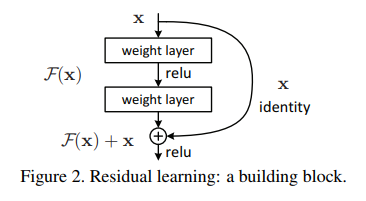
また、推論時にもニューラルネットワークは画像などの入力データの細部の情報と抽象的な情報両方を考慮することができる。

通常のCNNを用いると全ての情報が抽象化されてしまい、細部の情報が分からなくなってしまうが、その点をResNet,UNetなどはクリアー。
上の図は、ネットワークを関数として捉えた場合の、イメージ図。出力であるH(x) = F(x)+x となっている。xはそのブロックの入力値で、通常は中間層の特徴量マップや生画像が入る場合が多い。ResBlockの左側の流れは、線形変換を複数回繰り返すので、複雑な関数の形F(x)になる。右側のxは入力をそのまま出力層に渡すようになっており、あえて述べるなら係数が1.0、つまり1.0倍の変換をしていることになる。誤差逆伝搬法を用いる際に、右側の流れに関しては微分しても勾配の傾きが1.0になるので、勾配が消失しづらくなる。（注意：勾配が消失するというのは、傾きが0.00000.....001のようにほとんど無くなるということ）

ResNetが残差学習と呼ばれる理由は、F(x)=H(x)-xとなっており、入力xと出力H(x)がとても近くて残差（つまり引き算した結果）が0に近い場合でも、左側の重みは0に近くなり、右側の流れでそのまま渡すことで微妙な差をうまく学習することができる。

ResBlockの最終層でマージしているが、それは右側と左側から流れてきた全く同じサイズの特徴量マップ同士を、まったく同じ位置同士で足し合わせることを表現している。（×マークの時はアダマール積。要はCNN。最終層などで特徴量マップをマージする方法は、同じ位置どうしの足し算か、concatenateのどちらかが多い。)

<b>3rd partyのソースコードは　https://qiita.com/_odasi_/items/2d441e46643f73c0ca19　を参照。</b>
ただし、Kerasで実装したいときは数行で定義できる便利なものが標準で定義されている。

## どうでもいいTips 1:
CNNのフィルタの重みを正則化することができる方法がある。使い方は以下の通り。

```python
from keras.layers import Conv2D
from keras.regularizers import l2

def ResNetConv2D(*args, **kwargs):
    conv_kwargs = {
            'strides': (1, 1),
            'padding': 'same',
            'kernel_initializer': 'he_normal',
            'kernel_regularizer': l2(1.e-4)
    }
    conv_kwargs.update(kwargs)

    return Conv2D(*args, **conv_kwargs)

ResNetConv2D(filters=64, kernel_size=(7, 7), strides=(2, 2))
```

## どうでもいいTips2:
キーボードのアットマークとshiftキーを同時に押すと、クオーテーションマークを出すことができる。最初のクォーテーションマークの後にpythonと書き、その後ろにコードを書くとマークダウンの中にコードを書ける。
例：

\`\`\`python print("テスト") \`\`\`

```python 
print("テスト") 
```

エスケープシーケンスは円マークで書けます。

## どうでもいいTips3:
オライリーの「PythonとKerasによるディープラーニング」のソースコードが手に入ります。<br>
https://github.com/fchollet/deep-learning-with-python-notebooks

## KerasによるResNetの実装は以下のリンクを参照。
- https://gist.github.com/mjdietzx/0cb95922aac14d446a6530f87b3a04ce
- https://qiita.com/_odasi_/items/2d441e46643f73c0ca19

ここではQiitaの記事[3]について述べる。

Qiitaの記事のコードだと、F(x)の部分とxをResBlockで結合する際に、Add()を使用している。これは、同じ位置の特徴量マップ同士を足し算している。
似たようなコマンドにConcatenate()があるが、別物。
```python
Add()([shortcut, residual])
```
https://keras.io/ja/layers/merge/

また、ResNetのネットワークにBatchNormalizationも使っている。どこにBatchNormを挟めば良いか。通常はこんな感じ
```python
model.add(Convolution2D(64, 3, 3, use_bias=False))
model.add(BatchNormalization(axis=bn_axis))
model.add(Activation('relu'))
```

stackoverflow[4]によると、DenseやConv2Dなどの出力（線形変換する層）と、活性化関数の層（非線型変換する層）の間に挟むと良いと述べられている。
(詳しくはAnandさんに　笑)

出力層から少し手前のあたりで中間層から出てきた特徴量マップをGlobal Average Poolingに通して、次元を削減した後に、全結合層に通した。
出力層ではSoftmax関数というクラス分類に用いられる活性化関数に通し、出力。


# SEモジュールとGlobal Average Pooling

Squeeze-and-Excitation Networks[5]は、CNNを通した後の特徴量マップの相互依存性を考慮して、重要な特徴量マップを大きく定数倍し、重要でない（つまりノイズのような）特徴量マップを小さく定数倍することにより、小さなモデルサイズで精度を保つための手法。

SEモジュールの内部で、定数倍する際にどの大きさの値をかけたら良いかを導出するが、それはSqeeze(絞る)とExcition（励起）させることにより、求める。

...と論文には書かれていた。

## SEモジュール内部で定数倍するための定数を求める際に、なぜSqueezeする（ネットワークを絞る）か
SEモジュール内部では、Global Average Poolingをまず始めに行う。この時点で、既に特徴量マップの数と同じ数だけ値が求められているので、この値をそのまま特徴量マップに定数倍して出力しても良さそうに見える。しかし、Global Average Poolingの値（パターン）を入力として、どの層を何倍したら良いかという値を計算するための非線型変換を行う層を導入することにより、少しだけ性能が上がる。非線型変換をすること（つまり単純にDenseの層を追加すること）により、特徴量マップ同士の相関を推定することができる。

## SEモジュールのSqueezeの層をなぜ追加すると良いかイメージがわかない人はこちらを
イメージがわかない人は、架空の国の選挙や国会を考えると良い。ある法律を作るという決定をすることを目的とした時に、各地区の代表を選び（Global Average Pooling）、その代表に国会に出ていただき、議論をして法律を決める。SEモジュールの説明をするために架空の話をするが、それぞれの代表にも権力があり、人口の多い地区の国民（特徴量マップ）に選ばれた代表は、力を持っているので重要であり、人数が少ない地区の代表は力を持っていないとする。国会では力の強い人の意見を尊重するとする。ここまで説明したことはGlobal Average Poolingの値を使って、直接特徴量マップを定数倍して、推論した場合の話。

ここに、SqueezeとExcitionの考えを導入すると、権力のある議員の話だけばかりを尊重して、権力のない議員の話を尊重しないのはおかしいので、例えば

- 力のあるA議員が「No」と、力はなく、この分野については詳しくないB議員が「Yes」といった場合→A議員を尊重しよう 「No」
- 力のあるA議員が「No」と、力はないが特定の分野については詳しいB議員が「Yes」といった場合 → B議員を尊重しよう　「Yes」 

と、各議員の判断の組み合わせに応じて、何か傾向があるぞ、と総合的に考えることができる人を導入しよう、というのがSEモジュールを導入する意味。
上の例だと通常は力のある議員の判断だけを尊重すれば良いと考えるのが普通だが、議員の判断の組み合わせで状況に応じて最終的な決定を下すのがSEモジュールのSqueezeとExcitionの部分。


SE モジュールはResNetにも使える。F(x)とxの値をAddして次の層に渡すのがResBlockと述べたが、F(x)の出力の部分にSEモジュールを適用することもできる。ただし、特徴量マップのチャンネル数が減ってしまうのではないかと考えている。
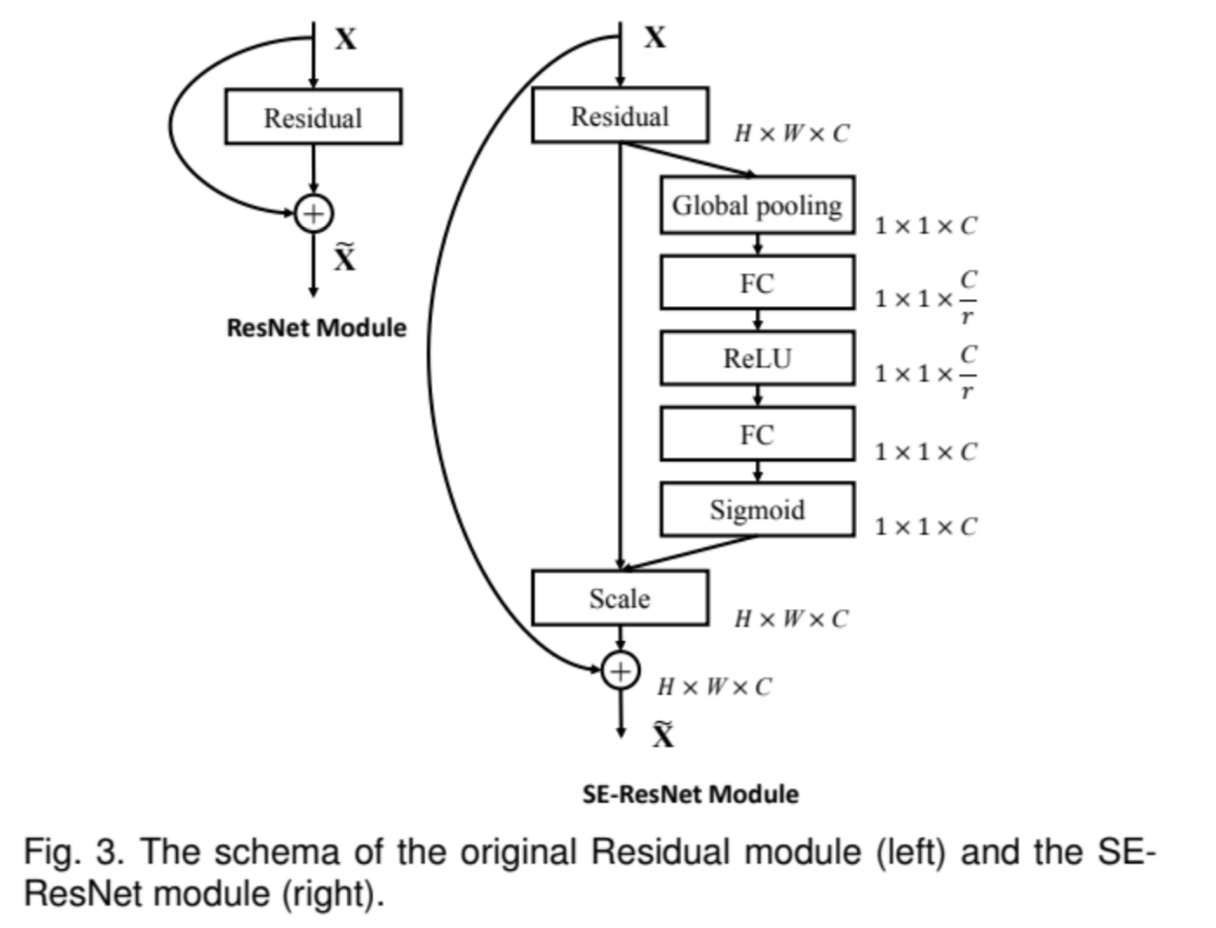